## **Import Libraries**

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier 
from sklearn.impute import SimpleImputer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV,train_test_split
import os

## **1. Load Data**

In [2]:
def load_raw_data(file_path):
    """Loads the raw data from a CSV file and sorts it by date."""
    try:
        df = pd.read_csv(file_path)
        print(f"Data loaded successfully from {file_path}")
        
        # Ensure the 'Date' column is in datetime format
        df['Date'] = pd.to_datetime(df['Date'])
        
        # Sort the DataFrame by date
        df = df.sort_values(by='Date').reset_index(drop=True)
        print("Data sorted by date.")
        
        return df
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None
    except pd.errors.EmptyDataError:
        print(f"Error: The file at {file_path} is empty")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

## **2. Feature Creation**

### **1. Rolling Statistics for Team Performance**
- Rolling team performance wins, looses, goals acored and conceded.

In [3]:
def calculate_rolling_stats(df, window, fill_missing=True):
    """
    Calculates rolling statistics for goals scored and conceded using optimized operations.

    Parameters:
        df (pd.DataFrame): Input DataFrame containing match data.
        window (int): The rolling window size for calculating statistics.
        fill_missing (bool): Whether to handle missing values.

    Returns:
        pd.DataFrame: DataFrame with rolling statistics features added.
    """
    # Define columns for rolling statistics
    rolling_features = {
        'goals_scored': ('FTHG', 'FTAG'),  # Home and Away goals scored
        'goals_conceded': ('FTAG', 'FTHG')  # Home and Away goals conceded
    }
    
    # Apply rolling calculations once for home and away teams
    for feature_name, (home_column, away_column) in rolling_features.items():
        df[f'home_rolling_{feature_name}'] = (
            df.groupby('HomeTeam')[home_column].transform(
                lambda x: x.rolling(window, min_periods=1).mean().shift(1)
            )
        )
        df[f'away_rolling_{feature_name}'] = (
            df.groupby('AwayTeam')[away_column].transform(
                lambda x: x.rolling(window, min_periods=1).mean().shift(1)
            )
        )

    # Handle missing values if required
    if fill_missing:
        rolling_columns = [col for col in df.columns if 'rolling_' in col]
        df[rolling_columns] = df[rolling_columns].fillna(0)

    print("Rolling statistics calculated using optimized operations.")
    return df


### **2. Shot Efficiency Metrics**
- Rolling average goals per shot per team

In [4]:
def calculate_shot_efficiency(df, window, fill_missing=True):
    """
    Calculates shot efficiency metrics for home and away teams using only past match data.

    Parameters:
        df (pd.DataFrame): Input DataFrame containing match data.
        window (int): The rolling window size for calculating metrics.
        fill_missing (bool): Whether to handle missing values.

    Returns:
        pd.DataFrame: DataFrame with shot efficiency metrics added.
    """
    # Define rolling efficiency calculation for home and away teams
    rolling_efficiency = {
        'shot_efficiency': ('FTHG', 'HS', 'FTAG', 'AS')  # Home and Away goals per shot
    }

    # Apply rolling calculations for both home and away teams
    for feature_name, (home_goals, home_shots, away_goals, away_shots) in rolling_efficiency.items():
        df[f'home_rolling_{feature_name}'] = (
            df.groupby('HomeTeam').apply(
                lambda group: (group[home_goals] / group[home_shots])
                .rolling(window, min_periods=1).mean().shift(1)
            ).reset_index(level=0, drop=True)
        )
        df[f'away_rolling_{feature_name}'] = (
            df.groupby('AwayTeam').apply(
                lambda group: (group[away_goals] / group[away_shots])
                .rolling(window, min_periods=1).mean().shift(1)
            ).reset_index(level=0, drop=True)
        )

    # Replace NaN or infinite values with 0 (e.g., if no shots were taken in past matches)
    rolling_columns = [col for col in df.columns if 'rolling_shot_efficiency' in col]
    df[rolling_columns] = df[rolling_columns].replace([float('inf'), -float('inf')], 0)

    # Handle missing values if required
    if fill_missing:
        df[rolling_columns] = df[rolling_columns].fillna(0)

    print("Shot efficiency metrics calculated using optimized operations.")
    return df


### **3. Dominance Metrics**
- Rolling dominance: shots, corners, and shot quality

In [5]:
def create_dominance_metrics(df, window, fill_missing=True):
    """
    Calculates dominance metrics (possession, shots, corners) using only past match data.

    Parameters:
        df (pd.DataFrame): Input DataFrame containing match data.
        window (int): Rolling window size for calculating metrics.
        fill_missing (bool): Whether to handle missing values.

    Returns:
        pd.DataFrame: DataFrame with dominance metrics added.
    """
    # Define dominance metrics for relative shots
    dominance_metrics = {
        'relative_shots': ('HS', 'AS')  # Home and Away shots differences
    }

    # Apply rolling calculations for both home and away teams
    for feature_name, (home_feature, away_feature) in dominance_metrics.items():
        df[f'home_rolling_{feature_name}'] = (
            df.groupby('HomeTeam').apply(
                lambda group: (group[home_feature] - group[away_feature])
                .rolling(window, min_periods=1).mean().shift(1)
            ).reset_index(level=0, drop=True)
        )
        df[f'away_rolling_{feature_name}'] = (
            df.groupby('AwayTeam').apply(
                lambda group: (group[away_feature] - group[home_feature])
                .rolling(window, min_periods=1).mean().shift(1)
            ).reset_index(level=0, drop=True)
        )

    # Handle missing values if required
    if fill_missing:
        rolling_columns = [col for col in df.columns if 'rolling_relative_shots' in col]
        df[rolling_columns] = df[rolling_columns].fillna(0)

    print("Dominance metrics calculated using optimized operations.")
    return df


### **4. Dicipline Metrics**
- Rolling yellow/red/foul discipline score.

In [6]:
def calculate_discipline_metrics(df, window, fill_missing=True):
    """
    Calculates discipline metrics (yellow cards, red cards, fouls) using only past match data.
    Optimized to reduce repeated groupby operations.

    Parameters:
        df (pd.DataFrame): The input DataFrame containing match data.
        window (int): The rolling window size for calculating metrics.
        fill_missing (bool): Whether to handle missing values.

    Returns:
        pd.DataFrame: The DataFrame with new discipline-related features added.
    """
    # Points for yellow and red cards
    yellow_card_points = 1
    red_card_points = 2

    # Define columns for rolling features
    rolling_features = {
        'fouls': ('HF', 'AF'),
        'yellow_cards': ('HY', 'AY'),
        'red_cards': ('HR', 'AR'),
    }
    
    # Apply rolling calculations once for home and away teams
    for feature_name, (home_column, away_column) in rolling_features.items():
        df[f'home_rolling_{feature_name}'] = (
            df.groupby('HomeTeam')[home_column].transform(
                lambda x: x.rolling(window, min_periods=1).mean().shift(1)
            )
        )
        df[f'away_rolling_{feature_name}'] = (
            df.groupby('AwayTeam')[away_column].transform(
                lambda x: x.rolling(window, min_periods=1).mean().shift(1)
            )
        )

    # Calculate discipline scores
    df['home_rolling_discipline_score'] = (
        df['home_rolling_yellow_cards'] * yellow_card_points +
        df['home_rolling_red_cards'] * red_card_points
    )
    df['away_rolling_discipline_score'] = (
        df['away_rolling_yellow_cards'] * yellow_card_points +
        df['away_rolling_red_cards'] * red_card_points
    )

    # Handle missing values if required
    if fill_missing:
        rolling_columns = [col for col in df.columns if 'rolling_' in col]
        df[rolling_columns] = df[rolling_columns].fillna(0)

    print("Discipline metrics calculated using optimized rolling operations.")
    return df


### **5. Time Based Features**

In [7]:
def create_time_based_features(df):
    """Creates time-based features (day of the week, month)."""
    df['day_of_week'] = df['Date'].dt.dayofweek
    df['month'] = df['Date'].dt.month
    print("Time-based features created")
    return df

### **6. Elo Ratings**

In [8]:
def add_elo_ratings(df, k_factor=25, initial_elo=1500):
    """Adds Elo ratings to the DataFrame."""
    elo_ratings = {}
    for team in df['HomeTeam'].unique():
        elo_ratings[team] = initial_elo

    home_elo = []
    away_elo = []

    for index, row in df.iterrows():
        home_team = row['HomeTeam']
        away_team = row['AwayTeam']

        # Get pre-match Elo ratings
        home_elo_rating = elo_ratings[home_team]
        away_elo_rating = elo_ratings[away_team]

        home_elo.append(home_elo_rating)
        away_elo.append(away_elo_rating)

        # Calculate expected outcome
        expected_home_score = 1 / (1 + 10 ** ((away_elo_rating - home_elo_rating) / 400))
        expected_away_score = 1 / (1 + 10 ** ((home_elo_rating - away_elo_rating) / 400))

        # Determine actual outcome
        if row['FTR'] == 'H':
            actual_home_score = 1
            actual_away_score = 0
        elif row['FTR'] == 'A':
            actual_home_score = 0
            actual_away_score = 1
        else:
            actual_home_score = 0.5
            actual_away_score = 0.5

        # Update Elo ratings
        elo_ratings[home_team] = home_elo_rating + k_factor * (actual_home_score - expected_home_score)
        elo_ratings[away_team] = away_elo_rating + k_factor * (actual_away_score - expected_away_score)

    # Add Elo ratings to the DataFrame
    df['home_elo'] = home_elo
    df['away_elo'] = away_elo
    print("Elo ratings calculated")
    return df


### **7. H2H**

In [9]:
def add_head_to_head_stats(df):
    """Adds head-to-head statistics to the DataFrame."""
    h2h_stats = []
    for index, row in df.iterrows():
        home_team = row['HomeTeam']
        away_team = row['AwayTeam']
        date = row['Date']

        # Filter historical matches between the two teams *before* the current date
        historical_matches = df[
            ((df['HomeTeam'] == home_team) & (df['AwayTeam'] == away_team)) |
            ((df['HomeTeam'] == away_team) & (df['AwayTeam'] == home_team))
        ]
        historical_matches = historical_matches[historical_matches['Date'] < date]

        # Calculate H2H statistics
        home_wins = len(historical_matches[
            ((historical_matches['HomeTeam'] == home_team) & (historical_matches['FTR'] == 'H')) |
            ((historical_matches['AwayTeam'] == home_team) & (historical_matches['FTR'] == 'A'))
        ])
        away_wins = len(historical_matches[
            ((historical_matches['HomeTeam'] == home_team) & (historical_matches['FTR'] == 'A')) |
            ((historical_matches['AwayTeam'] == home_team) & (historical_matches['FTR'] == 'H'))
        ])
        draws = len(historical_matches[historical_matches['FTR'] == 'D'])
        home_goal_diff = historical_matches[
            (historical_matches['HomeTeam'] == home_team)]['FTHG'].sum() - historical_matches[
            (historical_matches['HomeTeam'] == home_team)]['FTAG'].sum()
        away_goal_diff = historical_matches[
            (historical_matches['AwayTeam'] == home_team)]['FTAG'].sum() - historical_matches[
            (historical_matches['AwayTeam'] == home_team)]['FTHG'].sum()
        goal_difference = home_goal_diff + away_goal_diff

        h2h_stats.append([home_wins, away_wins, draws, goal_difference])

    # Add H2H statistics to the DataFrame
    h2h_df = pd.DataFrame(h2h_stats, columns=[
        'h2h_home_wins', 'h2h_away_wins', 'h2h_draws', 'h2h_goal_difference'
    ])
    df = pd.concat([df, h2h_df], axis=1)
    print("Head-to-head statistics calculated")
    return df

### **8.Market value Differential**

In [10]:
def calculate_market_value_differential(df):
    """
    Calculates the differential between Home Team Market Value and Away Team Market Value.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame containing 'HT_MarketValue_inM' and 'AT_MarketValue_inM' columns.
    
    Returns:
        pd.DataFrame: The DataFrame with a new column 'MarketValue_Differential' added.
    """
    if 'HT_MarketValue_inM' not in df.columns or 'AT_MarketValue_inM' not in df.columns:
        raise ValueError("The DataFrame must contain 'HT_MarketValue_inM' and 'AT_MarketValue_inM' columns.")
    
    # Calculate the differential
    df['MarketValue_Differential'] = df['HT_MarketValue_inM'] - df['AT_MarketValue_inM']
    print("Market value differential calculated and added as 'MarketValue_Differential'.")
    return df

### **Apply all the engineered steps**
- A wrapper to run them all in sequence

In [11]:
def generate_all_features(window=5, fill_missing=True):
    """
    Load EDA cleaned dataset and generate all features for the dataset, including rolling stats, shot efficiency,    
    dominance metrics, discipline metrics, and time-based features.
    """
    # print(f"Generating features with window = {window}...")
    file_path = "/Users/fitsumbahlebi/Desktop/repo2/PremierLeagueMatchPredictor/Data/Processed/epl_cleaned.csv"
    print("Loading Dataset...")
    df = load_raw_data(file_path)
    print("Generating Rolling Team Performance features...")
    df = calculate_rolling_stats(df, window)
    print("Generating Shot Efficiency features...")
    df = calculate_shot_efficiency(df, window)
    print("Generating Dominance metrics...")
    df = create_dominance_metrics(df, window)
    print("Generating Discipline metrics...")
    df = calculate_discipline_metrics(df, window)
    print("Generating Time-based features...")
    df = create_time_based_features(df)
    print("Adding Elo ratings...")
    df = add_elo_ratings(df)
    print("Adding Head-to-Head statistics...")
    df = add_head_to_head_stats(df)
    print("Calculating Market Value Differential...")
    df = calculate_market_value_differential(df)
    print("Feature generation complete!")

    
    
    return df

# Generate all features
epl_engineered = generate_all_features(window=7, fill_missing=True)
print(f"Shape of the engineered data:{epl_engineered.shape}")
print(epl_engineered.head())
print("=======================")
print(epl_engineered.isnull().sum().sort_values(ascending=False))
print("=======================")





Loading Dataset...
Data loaded successfully from /Users/fitsumbahlebi/Desktop/repo2/PremierLeagueMatchPredictor/Data/Processed/epl_cleaned.csv
Data sorted by date.
Generating Rolling Team Performance features...
Rolling statistics calculated using optimized operations.
Generating Shot Efficiency features...
Shot efficiency metrics calculated using optimized operations.
Generating Dominance metrics...
Dominance metrics calculated using optimized operations.
Generating Discipline metrics...
Discipline metrics calculated using optimized rolling operations.
Generating Time-based features...
Time-based features created
Adding Elo ratings...
Elo ratings calculated
Adding Head-to-Head statistics...
Head-to-head statistics calculated
Calculating Market Value Differential...
Market value differential calculated and added as 'MarketValue_Differential'.
Feature generation complete!
Shape of the engineered data:(6749, 46)
        Date       HomeTeam    AwayTeam  FTHG  FTAG FTR    Referee    HS  \


## **3. Feature Selection**

### **1. Correlation Analysis**

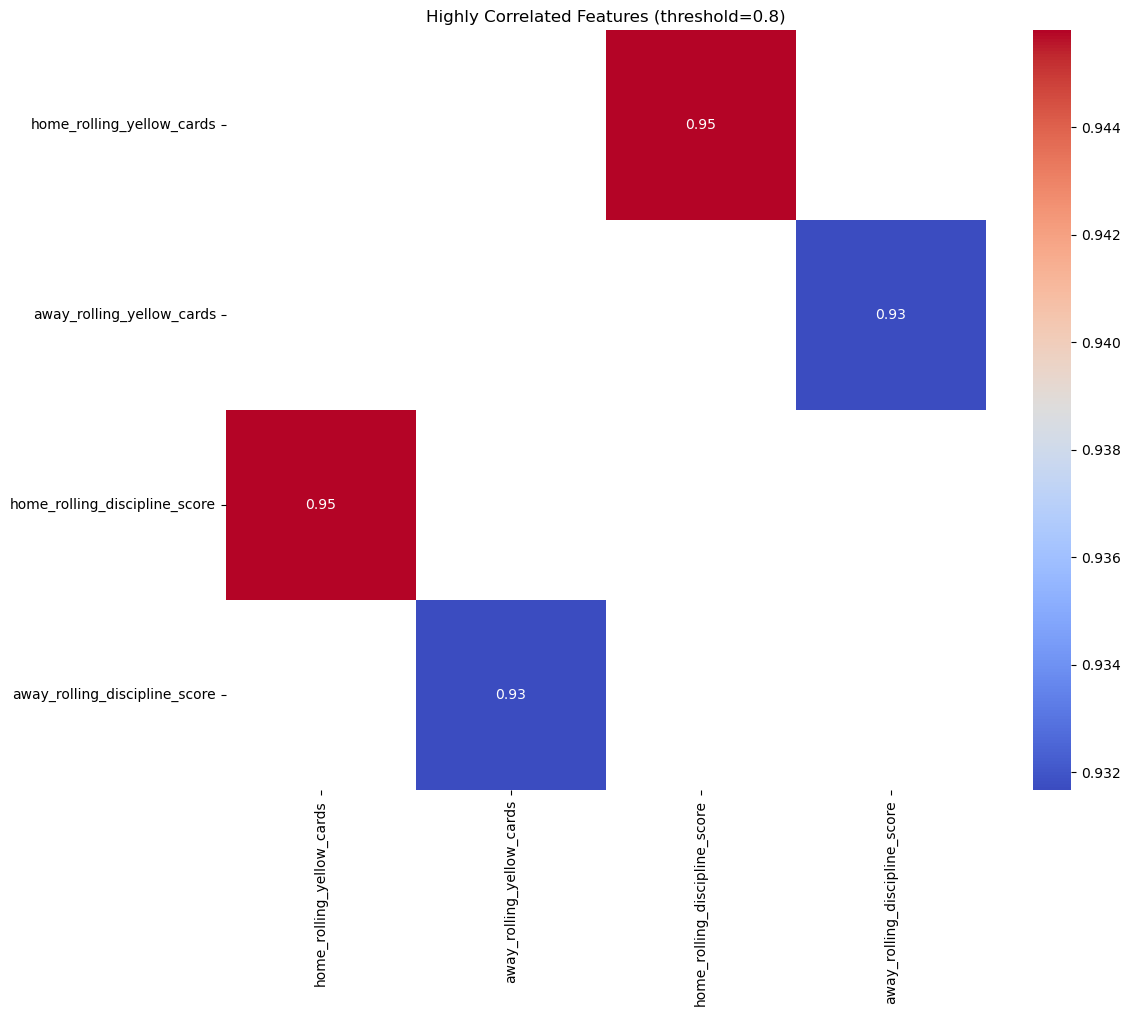

In [12]:
def plot_correlation_matrix(df, threshold=0.85):
    # Only numeric features
    numeric_df = df.select_dtypes(include=['number'])
    corr = numeric_df.corr().abs()

    # Masking low correlations
    high_corr = corr.where((corr > threshold) & (corr < 1.0)).dropna(how='all').dropna(axis=1, how='all')

    if high_corr.empty:
        print("No feature pairs with correlation above threshold.")
        return
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(high_corr, annot=True, cmap='coolwarm', square=True)
    plt.title(f'Highly Correlated Features (threshold={threshold})')
    plt.tight_layout()
    plt.show()

# Plot correlation matrix
plot_correlation_matrix(epl_engineered, threshold=0.80)


### Correlation Analysis Observations

- **Key Findings**:
    - Strong correlations between yellow cards and discipline score (**home: 0.95**, **away: 0.93**) indicate redundancy.
    - Red cards contribute less significantly compared to yellow cards.

- **Plan**:
    - Drop **home_rolling_yellow_cards** and **away_rolling_yellow_cards**; retain discipline score for better clarity.

- **Next Steps**:
    - Perform Multicollinearity Analysis to assess interactions among remaining features.
    



### **2. Identify and Handle Multicollinearity**


In [13]:
def compute_vif(df):
    numeric_df = df.select_dtypes(include=['number']).dropna()
    cols_to_drop = [
                    'home_rolling_yellow_cards', 'away_rolling_yellow_cards',
                    'HT_MarketValue_inM', 'AT_MarketValue_inM','h2h_away_wins',
                    'h2h_home_wins','home_rolling_red_cards','away_rolling_red_cards'
                    ]
    numeric_df = numeric_df.drop(columns=cols_to_drop, errors='ignore')
    X = StandardScaler().fit_transform(numeric_df)
    vif_data = pd.DataFrame()
    vif_data["feature"] = numeric_df.columns
    vif_data["VIF"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
    return vif_data.sort_values(by="VIF", ascending=False)
# Compute VIF
vif_data = compute_vif(epl_engineered)
display(vif_data)



,feature,VIF
14,home_rolling_goals_scored,6.534554
15,away_rolling_goals_scored,5.665364
18,home_rolling_shot_efficiency,4.232763
28,home_elo,4.188826
32,MarketValue_Differential,4.187029
29,away_elo,4.169883
19,away_rolling_shot_efficiency,3.776463
20,home_rolling_relative_shots,3.556963
21,away_rolling_relative_shots,2.812939
2,HS,2.586590


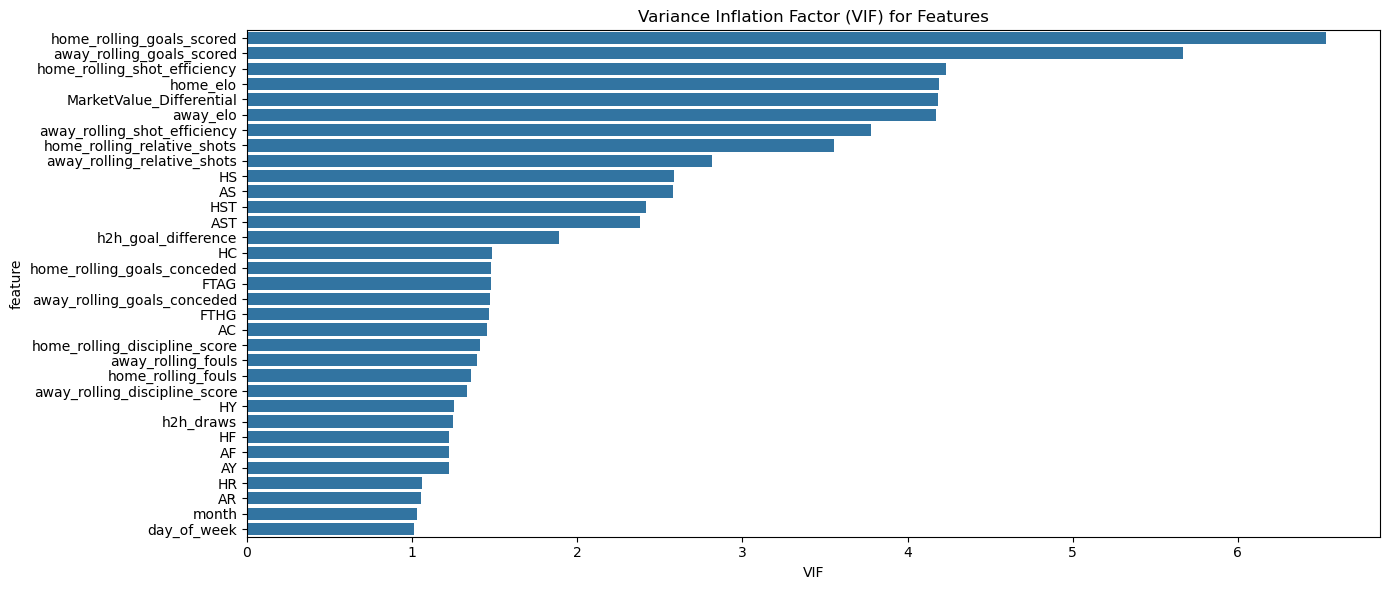

In [14]:
# Plot VIF data
plt.figure(figsize=(14, 6))
sns.barplot(x='VIF', y='feature', data=vif_data)
plt.title('Variance Inflation Factor (VIF) for Features')
plt.tight_layout()
plt.show()

- **Multicollinearity Analysis Summary**

- **Key Observations:**
  - **Before Feature Removal**:
    - Perfect multicollinearity observed in discipline scores and yellow/red cards metrics (e.g., VIF = ∞).
    - Highly multicollinear head-to-head features (e.g., `h2h_goal_difference`, VIF > 10).
  - **After Feature Removal**:
    - Redundancy resolved by removing yellow/red card metrics.
    - Moderate multicollinearity retained in `home_rolling_goals_scored` (VIF = 6.53) and `MarketValue_Differential` (VIF = 4.18), which are critical predictors.

- **Key Improvements:**
  - Multicollinearity significantly reduced.
  - Essential predictors retained for improved model clarity.

- **Next Steps:**
  - Assess the predictive contribution of features using a tree model.


### **3. Feature Importance Using Tree-Based Model**


Top 20 Feature Importances using Random Forest:
                          Feature  Importance
4        MarketValue_Differential    0.101422
5                        away_elo    0.078948
3                        home_elo    0.075355
8     home_rolling_relative_shots    0.065425
9     away_rolling_relative_shots    0.065388
2    home_rolling_shot_efficiency    0.060660
6    away_rolling_shot_efficiency    0.059108
16             home_rolling_fouls    0.051916
15             away_rolling_fouls    0.051304
10            h2h_goal_difference    0.047208
0       home_rolling_goals_scored    0.043776
14  home_rolling_discipline_score    0.043624
17  away_rolling_discipline_score    0.043288
13    away_rolling_goals_conceded    0.042538
12    home_rolling_goals_conceded    0.040399
1       away_rolling_goals_scored    0.038774
11                          month    0.036696
18                      h2h_draws    0.027262
7                     day_of_week    0.026908


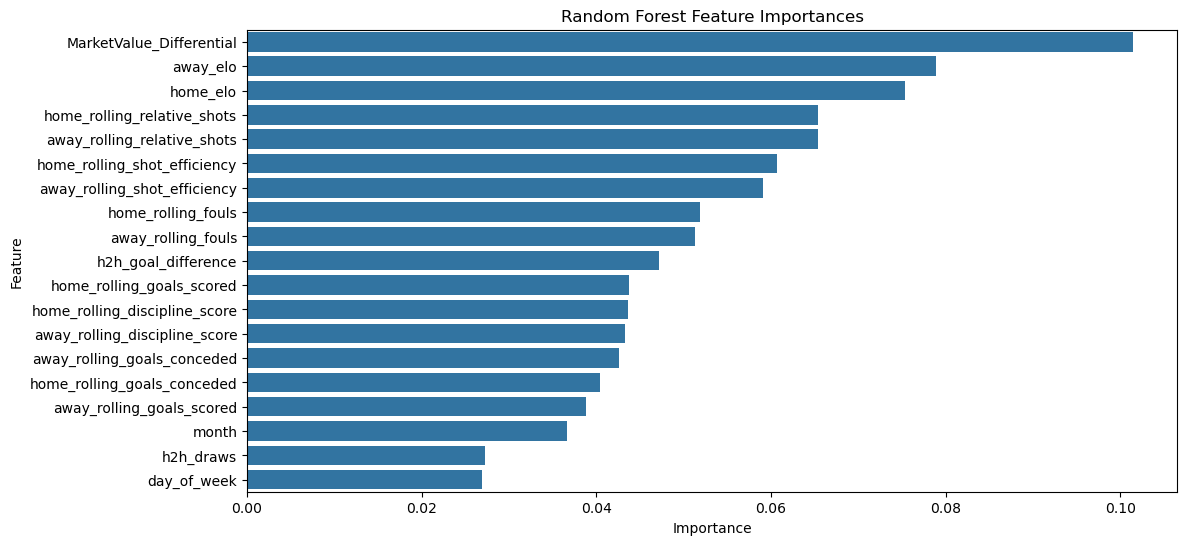

In [15]:
def preprocess_and_model(epl_engineered, test_size=0.2):
    """
    Preprocesses the EPL dataset for time series analysis, selects features, 
    and builds a Random Forest model to calculate feature importance.

    Parameters:
        epl_engineered (pd.DataFrame): Engineered dataset containing match data.
        test_size (float): Proportion of data used for testing.

    Returns:
        feature_importances (pd.DataFrame): Feature importance metrics from the Random Forest model.
    """
    # Ensure 'Date' is in datetime format and sort dataset by date
    if 'Date' in epl_engineered.columns:
        epl_engineered['Date'] = pd.to_datetime(epl_engineered['Date'])
        epl_engineered = epl_engineered.sort_values(by='Date')
    else:
        raise ValueError("Dataset must contain a 'Date' column for proper time series analysis.")

    # Define the target variable and features
    if 'FTR' in epl_engineered.columns:
        y = epl_engineered['FTR']
    else:
        raise ValueError("No target variable found. Ensure 'FTR' is present in the dataset.")

    # Select pre-match features excluding match-level data (e.g., HS, HST, FTHG)
    selected_features = [
    'home_rolling_goals_scored','away_rolling_goals_scored','home_rolling_shot_efficiency',
    'home_elo','MarketValue_Differential','away_elo','away_rolling_shot_efficiency','day_of_week',
    'home_rolling_relative_shots','away_rolling_relative_shots','h2h_goal_difference','month',
    'home_rolling_goals_conceded','away_rolling_goals_conceded','home_rolling_discipline_score',
    'away_rolling_fouls','home_rolling_fouls','away_rolling_discipline_score','h2h_draws'
    
]
    X = epl_engineered[selected_features]

    # Handle missing values
    imputer = SimpleImputer(strategy='mean')
    X_imputed = imputer.fit_transform(X)
    X = pd.DataFrame(X_imputed, columns=selected_features)

    # Ensure the data is sorted by date for time series analysis
    split_index = int(len(X) * (1 - test_size))
    X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
    y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

    # Train a Random Forest model on training data
    rf_model = RandomForestClassifier(random_state=42)
    rf_model.fit(X_train, y_train)

    # Calculate feature importances
    feature_importances = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': rf_model.feature_importances_
    }).sort_values(by='Importance', ascending=False)

    # Print and visualize feature importances
    print("Top 20 Feature Importances using Random Forest:")
    print(feature_importances.head(20))

    plt.figure(figsize=(12, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importances.head(20))
    plt.title('Random Forest Feature Importances')
    plt.show()

    return feature_importances

# Preprocess and model the data
feature_importances = preprocess_and_model(epl_engineered, test_size=0.2)


- **Feature Importance Analysis Summary**

- **Key Findings:**
- **High Impact Features**:
  - *MarketValue_Differential* (Importance = 0.101): Most impactful predictor, representing the difference in market values.
  - *away_elo* (Importance = 0.079) & *home_elo* (Importance = 0.075): Elo ratings highlight team strength.
  - *Rolling Metrics*:
    - *home_rolling_relative_shots* (Importance = 0.065) & *away_rolling_relative_shots* (Importance = 0.065): Indicate shot dominance.
    - *Shot efficiency* metrics (*home*: 0.061, *away*: 0.059): Evaluate conversion efficiency.

- **Moderate Features**:
  - Temporal factors like *month* (Importance = 0.037) and *day_of_week* (Importance = 0.027) reveal situational influences.


This analysis highlights the features with the most predictive power and establishes priorities for model refinement.


## **4. Visualizing Home vs Away Performance for Key Features**

/var/folders/3v/n_hcqvnj2q9bxvssr6zjwkc80000gp/T/ipykernel_5069/1992695670.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_feature, x='Location', y=feature, palette='viridis')


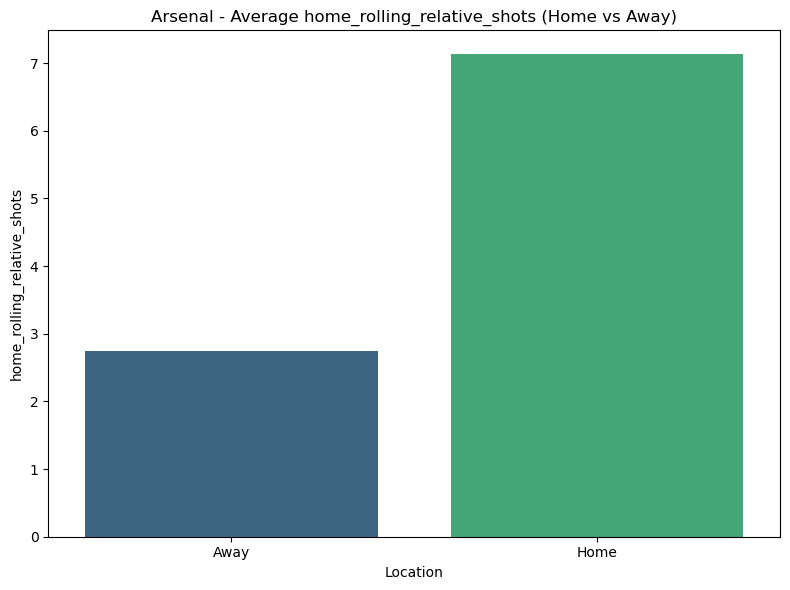

In [20]:
def plot_bar_chart(df, team_name, feature):
    """
    Plots a bar chart comparing home and away performance for a specific feature.

    Parameters:
        df (pd.DataFrame): The DataFrame containing match data.
        team_name (str): The name of the team to plot.
        feature (str): The feature to visualize (e.g., 'home_rolling_relative_shots').
    """
    team_data = df[(df['HomeTeam'] == team_name) | (df['AwayTeam'] == team_name)].copy()
    team_data['Location'] = np.where(team_data['HomeTeam'] == team_name, 'Home', 'Away')
    avg_feature = team_data.groupby('Location')[feature].mean().reset_index()

    plt.figure(figsize=(8, 6))
    sns.barplot(data=avg_feature, x='Location', y=feature, palette='viridis')
    plt.title(f"{team_name} - Average {feature} (Home vs Away)")
    plt.ylabel(feature)
    plt.xlabel("Location")
    plt.tight_layout()
    plt.show()

# Example usage
plot_bar_chart(epl_engineered, 'Arsenal', 'home_rolling_relative_shots')

- The engineered features reaffirm the presence of a clear home advantage compared to away games, aligning with the initial findings from the preprocessing notebook.

## **5. Save Selected Engineered data**

In [27]:
def filter_and_save_dataframe(dataframe, selected_features, file_path="epl_engineered.csv"):
    """
    Filters the DataFrame to retain only selected columns, saves it to a specified file path, 
    and displays the number of columns before and after filtering.

    Parameters:
        dataframe (pd.DataFrame): The input DataFrame to filter and save.
        selected_features (list): List of columns to retain in the filtered DataFrame.
        file_path (str): File path to save the filtered DataFrame (default: 'epl_engineered.csv').
    """
    # Show the number of columns before filtering
    initial_columns = dataframe.shape[1]
    print(f"Number of columns before filtering: {initial_columns}")

    # Filter the DataFrame to include only the selected features
    filtered_dataframe = dataframe[selected_features]

    # Show the number of columns after filtering
    final_columns = filtered_dataframe.shape[1]
    print(f"Number of columns after filtering: {final_columns}")

    # Save the filtered DataFrame to the specified file path
    filtered_dataframe.to_csv(file_path, index=False)
    print(f"Filtered DataFrame saved to '{file_path}'.")

# Example usage:
selected_features = [
    'MarketValue_Differential', 'away_elo', 'home_elo', 
    'home_rolling_relative_shots', 'away_rolling_relative_shots', 
    'home_rolling_shot_efficiency', 'away_rolling_shot_efficiency', 
    'home_rolling_fouls', 'away_rolling_fouls', 'h2h_goal_difference', 
    'home_rolling_goals_scored', 'away_rolling_goals_scored', 
    'home_rolling_discipline_score', 'away_rolling_discipline_score', 
    'home_rolling_goals_conceded', 'away_rolling_goals_conceded', 
    'month', 'day_of_week', 'FTR','Date', 'HomeTeam', 'AwayTeam'
]

# Dynamically generate the file path by appending the file name to the provided path
base_path = '/Users/fitsumbahlebi/Desktop/repo2/PremierLeagueMatchPredictor/Data/Processed'
file_name = 'epl_engineered_filtered.csv'
full_path = os.path.join(base_path, file_name)

# Call the function to filter and save the DataFrame to the dynamically generated path
filter_and_save_dataframe(epl_engineered, selected_features, file_path=full_path)


Number of columns before filtering: 46
Number of columns after filtering: 22
Filtered DataFrame saved to '/Users/fitsumbahlebi/Desktop/repo2/PremierLeagueMatchPredictor/Data/Processed/epl_engineered_filtered.csv'.
